In [312]:
import pandas as pd
import numpy as np
import pymc3 as pm
import graphviz
import arviz as az
import seaborn as sns

In [2]:
df = pd.read_csv('population_housing_join.csv', index_col=0)
df

,city,state,year,births_census,censuspop_census,deaths_census,domesticmig_census,estimatesbase_census,internationalmig_census,naturalinc_census,netmig_census,npopchg_census,popestimate_census,residual_census,med_zhvi,med_zori
0,Abilene,TX,2010,541.0,165252.0,410.0,123.0,165252.0,89.0,131.0,212.0,338.0,165590.0,-5.0,101849.5,NaN
1,Abilene,TX,2011,2292.0,NaN,1501.0,68.0,NaN,206.0,791.0,274.0,1061.0,166651.0,-4.0,98293.5,NaN
2,Abilene,TX,2012,2359.0,NaN,1590.0,-456.0,NaN,529.0,769.0,73.0,832.0,167483.0,-10.0,100745.0,NaN
3,Abilene,TX,2013,2391.0,NaN,1691.0,-1064.0,NaN,373.0,700.0,-691.0,32.0,167515.0,23.0,101952.5,NaN
4,Abilene,TX,2014,2385.0,NaN,1597.0,-308.0,NaN,433.0,788.0,125.0,893.0,168408.0,-20.0,108733.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4219,Yuma,AZ,2016,3007.0,NaN,1511.0,-441.0,NaN,932.0,1496.0,491.0,1975.0,207162.0,-12.0,139248.0,NaN
4220,Yuma,AZ,2017,3006.0,NaN,1457.0,-40.0,NaN,581.0,1549.0,541.0,2082.0,209244.0,-8.0,147331.0,NaN
4221,Yuma,AZ,2018,2916.0,NaN,1594.0,374.0,NaN,314.0,1322.0,688.0,2001.0,211245.0,-9.0,155471.5,NaN
4222,Yuma,AZ,2019,3104.0,NaN,1659.0,777.0,NaN,720.0,1445.0,1497.0,2937.0,214182.0,-5.0,161821.0,NaN


In [7]:
order = 3

predictors = [
  'popestimate_census',
  'med_zhvi',
  'deaths_census'
]

output='med_zhvi'

We're doing modified autoregression because we're not estimating all of our predictors, we won't have a **prediction** past the next year unless we had a prediction for all of our predictors as well that we could feed back into the model. We'll either only be predicting for the next time slot or we'll have to come up with posterior models for each predictor to then feed back into the model. 

In [21]:
def generate_time_data(df, city, order, predictors, outputs):

  df = df.query(F"city== '{city}'")

  df_input = pd.DataFrame()
  years = []
  for year in range(df.year.min()+order, df.year.max()+1):

    df2 = df.query(F"year < {year} & year >= {year}-{order}")
    df2['step'] = [i for i in range(order)]
    df_pivot = df2.pivot(index='city', columns='step', values=predictors).reset_index()

    # Get relevant outputs
    out = df.query(F"year == {year}").reset_index(drop=True)[outputs[0]].loc[0]
    out2 = df.query(F"year == {year}").reset_index(drop=True)[outputs[1]].loc[0]
    out3 = df.query(F"year == {year}").reset_index(drop=True)[outputs[2]].loc[0]

    df_pivot['out'] = out
    df_pivot['out2'] = out2
    df_pivot['out3'] = out3    

    df_pivot = df_pivot.rename({'out':outputs[0],'out2':outputs[1],'out3':outputs[2]}, axis=1)
    df_input = pd.concat([df_input, df_pivot])
    years.append(year)

  df_input.insert(1, 'year',years)
  df_input = df_input.reset_index(drop=True)
  df_input.columns=[str(col[0]) + str(col[1]) for col in df_input.columns.values]
  return df_input

generate_time_data(df=df, city='Charlottesville',order=4, predictors = predictors, outputs=['med_zhvi', 'popestimate_census', 'deaths_census'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,city,year,popestimate_census0,popestimate_census1,popestimate_census2,popestimate_census3,med_zhvi0,med_zhvi1,med_zhvi2,med_zhvi3,deaths_census0,deaths_census1,deaths_census2,deaths_census3,med_zhvi,popestimate_census,deaths_census
0,Charlottesville,2014,201913.0,203683.0,205636.0,206887.0,269473.0,259929.0,259257.0,263915.5,423.0,1479.0,1477.0,1637.0,270048.0,209351.0,1554.0
1,Charlottesville,2015,203683.0,205636.0,206887.0,209351.0,259929.0,259257.0,263915.5,270048.0,1479.0,1477.0,1637.0,1554.0,272673.5,211691.0,1729.0
2,Charlottesville,2016,205636.0,206887.0,209351.0,211691.0,259257.0,263915.5,270048.0,272673.5,1477.0,1637.0,1554.0,1729.0,277095.0,213980.0,1652.0
3,Charlottesville,2017,206887.0,209351.0,211691.0,213980.0,263915.5,270048.0,272673.5,277095.0,1637.0,1554.0,1729.0,1652.0,288738.0,216488.0,1705.0
4,Charlottesville,2018,209351.0,211691.0,213980.0,216488.0,270048.0,272673.5,277095.0,288738.0,1554.0,1729.0,1652.0,1705.0,300367.5,217739.0,1696.0
5,Charlottesville,2019,211691.0,213980.0,216488.0,217739.0,272673.5,277095.0,288738.0,300367.5,1729.0,1652.0,1705.0,1696.0,311332.0,219160.0,1808.0
6,Charlottesville,2020,213980.0,216488.0,217739.0,219160.0,277095.0,288738.0,300367.5,311332.0,1652.0,1705.0,1696.0,1808.0,318076.5,219910.0,1932.0


## Format Data for model input

In [22]:
cville = generate_time_data(df=df, city='Charlottesville',order=2, predictors=predictors, outputs=['med_zhvi','popestimate_census','deaths_census'])
cville

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,city,year,popestimate_census0,popestimate_census1,med_zhvi0,med_zhvi1,deaths_census0,deaths_census1,med_zhvi,popestimate_census,deaths_census
0,Charlottesville,2012,201913.0,203683.0,269473.0,259929.0,423.0,1479.0,259257.0,205636.0,1477.0
1,Charlottesville,2013,203683.0,205636.0,259929.0,259257.0,1479.0,1477.0,263915.5,206887.0,1637.0
2,Charlottesville,2014,205636.0,206887.0,259257.0,263915.5,1477.0,1637.0,270048.0,209351.0,1554.0
3,Charlottesville,2015,206887.0,209351.0,263915.5,270048.0,1637.0,1554.0,272673.5,211691.0,1729.0
4,Charlottesville,2016,209351.0,211691.0,270048.0,272673.5,1554.0,1729.0,277095.0,213980.0,1652.0
5,Charlottesville,2017,211691.0,213980.0,272673.5,277095.0,1729.0,1652.0,288738.0,216488.0,1705.0
6,Charlottesville,2018,213980.0,216488.0,277095.0,288738.0,1652.0,1705.0,300367.5,217739.0,1696.0
7,Charlottesville,2019,216488.0,217739.0,288738.0,300367.5,1705.0,1696.0,311332.0,219160.0,1808.0
8,Charlottesville,2020,217739.0,219160.0,300367.5,311332.0,1696.0,1808.0,318076.5,219910.0,1932.0


## Generate Model for zvhi

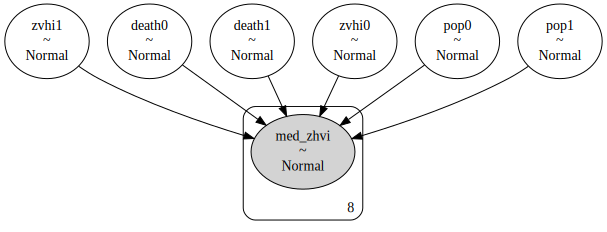

In [125]:
sig = 1000
with pm.Model() as model:

  pop0 = pm.Normal(name='pop0', mu=0, sigma=sig)
  pop1 = pm.Normal(name='pop1', mu=0, sigma=200)

  zhvi0 = pm.Normal(name='zvhi0', mu=0, sigma=sig)
  zhvi1 = pm.Normal(name='zvhi1', mu=0, sigma=sig)

  death0 = pm.Normal(name='death0', mu=0, sigma=sig)
  death1 = pm.Normal(name='death1', mu=0, sigma=sig)

  theta = (pop0*cville.popestimate_census0 + 
           pop1*cville.popestimate_census1 + 
           zhvi0*cville.med_zhvi0 + 
           zhvi1*cville.med_zhvi1 + 
           death0*cville.deaths_census0 +
           death1*cville.deaths_census1
  )

  med_zhvi = pm.Normal('med_zhvi', theta, sd=200, observed=cville.med_zhvi)

pm.model_to_graphviz(model)


In [182]:
with model:
    trace = pm.sample(10000)
    idata = az.from_pymc3(trace)
az.summary(idata, round_to=2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [death1, death0, zvhi1, zvhi0, pop1, pop0]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 3424 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pop0,0.16,0.16,-0.15,0.46,0.00,0.00,5416.74,8856.98,1.00
pop1,-0.35,0.19,-0.71,-0.00,0.08,0.06,5.77,24.35,1.25
zvhi0,-0.26,0.17,-0.46,0.02,0.11,0.09,2.58,11.17,2.22
zvhi1,1.41,0.11,1.22,1.54,0.07,0.06,2.59,11.21,2.19
death0,2.34,2.17,-0.04,5.80,1.46,1.23,2.57,13.12,2.51
death1,1.57,1.81,-0.51,5.18,1.06,0.84,3.16,10.87,1.94


## Generate Model for Population

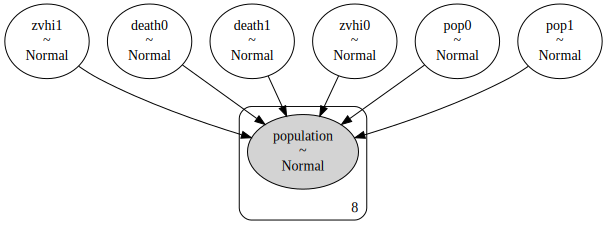

In [135]:
sig = 1000
with pm.Model() as model_death:

  pop0 = pm.Normal(name='pop0', mu=0, sigma=sig)
  pop1 = pm.Normal(name='pop1', mu=0, sigma=200)

  zhvi0 = pm.Normal(name='zvhi0', mu=0, sigma=sig)
  zhvi1 = pm.Normal(name='zvhi1', mu=0, sigma=sig)

  death0 = pm.Normal(name='death0', mu=0, sigma=sig)
  death1 = pm.Normal(name='death1', mu=0, sigma=sig)

  theta = (pop0*cville.popestimate_census0 + 
           pop1*cville.popestimate_census1 + 
           zhvi0*cville.med_zhvi0 + 
           zhvi1*cville.med_zhvi1 + 
           death0*cville.deaths_census0 +
           death1*cville.deaths_census1
  )

  population = pm.Normal('population', theta, sd=200, observed=cville.popestimate_census)

pm.model_to_graphviz(model_pop)


In [137]:
with model_pop:
    pop_trace = pm.sample(100)
    pop_idata = az.from_pymc3(trace)
az.summary(pop_idata, round_to=2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [death1, death0, zvhi1, zvhi0, pop1, pop0]


Sampling 2 chains for 1_000 tune and 100 draw iterations (2_000 + 200 draws total) took 203 seconds.
The acceptance probability does not match the target. It is 0.8806656315640121, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pop0,0.11,0.16,-0.19,0.39,0.04,0.03,18.24,47.12,1.08
pop1,0.92,0.16,0.59,1.17,0.04,0.03,19.49,27.34,1.08
zvhi0,0.02,0.04,-0.04,0.10,0.01,0.00,57.48,131.34,1.01
zvhi1,-0.06,0.03,-0.11,-0.01,0.00,0.00,42.24,121.28,1.00
death0,0.17,0.45,-0.67,1.01,0.06,0.05,51.18,149.90,1.01
death1,4.07,1.14,2.02,6.12,0.16,0.12,55.40,58.80,1.02


In [181]:
ppc = pm.sample_posterior_predictive(trace, model=model, samples=1000)
ppc['med_zhvi']

/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


array([[258479.57271768, 263340.16648076, 269471.65514751, ...,
        284798.27604893, 298019.88531902, 312430.42022069],
       [259044.32579433, 263872.82955087, 269582.68515374, ...,
        284600.42859299, 298002.16759503, 312193.62978451],
       [258889.43342422, 262988.40948538, 269607.77557073, ...,
        284482.30651692, 297971.33009383, 312648.75136929],
       ...,
       [259172.65645841, 263518.93535979, 269495.2837624 , ...,
        284757.59266569, 297878.50272657, 312357.2612972 ],
       [259263.56788424, 263269.69493714, 269406.05888118, ...,
        284290.02907856, 297574.0748509 , 312474.65194192],
       [259109.07474312, 263042.44943979, 269966.81165467, ...,
        284961.14583698, 298000.98633869, 312388.80302896]])

### Get Predictions and Error

In [180]:
preds = []
sigs = []

for i in range(ppc['med_zhvi'].shape[1]):
  preds.append(round(np.average(ppc['med_zhvi'][i]),2))
  sigs.append(round(np.std(ppc['med_zhvi'][i]),2))

df_preds = pd.DataFrame({
    'year':cville.year,
    'med_zhvi':cville.med_zhvi,
    'prediction':preds,
    'stdev':sigs
})

df_preds['pct_error'] = round(100*(df_preds.prediction - df_preds.med_zhvi)/df_preds.med_zhvi,2)
df_preds

,year,med_zhvi,prediction,stdev,pct_error
0,2012,259257.0,280314.94,16829.78,8.12
1,2013,263915.5,280519.83,16755.57,6.29
2,2014,270048.0,280506.12,16716.24,3.87
3,2015,272673.5,280367.10,16672.14,2.82
4,2016,277095.0,280295.67,16578.34,1.16
5,2017,288738.0,280462.77,16680.16,-2.87
6,2018,300367.5,280394.68,16889.26,-6.65
7,2019,311332.0,280342.66,16496.59,-9.95


# Attempting a combined model for VAR

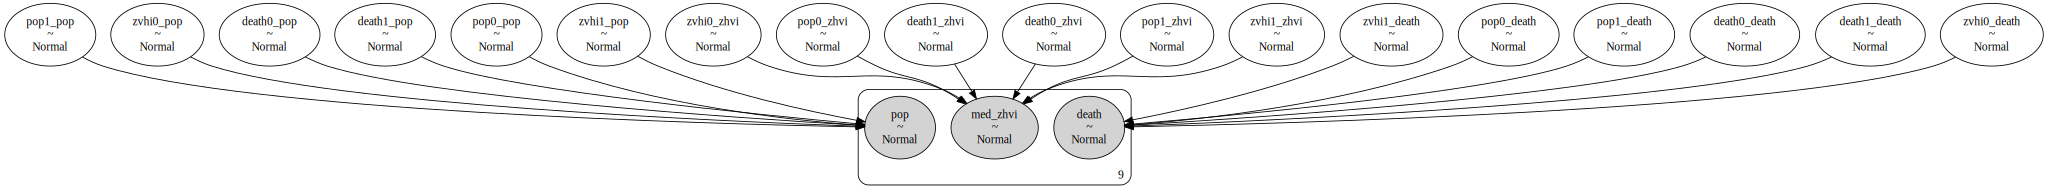

In [239]:
sig = 1000
with pm.Model() as model_comb:

  # ZHVI Parameters
  pop0_zhvi = pm.Normal(name='pop0_zhvi', mu=0, sigma=sig)
  pop1_zhvi = pm.Normal(name='pop1_zhvi', mu=0, sigma=200)

  zhvi0_zhvi = pm.Normal(name='zvhi0_zhvi', mu=0, sigma=sig)
  zhvi1_zhvi = pm.Normal(name='zvhi1_zhvi', mu=0, sigma=sig)

  death0_zhvi = pm.Normal(name='death0_zhvi', mu=0, sigma=sig)
  death1_zhvi = pm.Normal(name='death1_zhvi', mu=0, sigma=sig)

  theta_zhvi = (pop0_zhvi*cville.popestimate_census0 + 
           pop1_zhvi*cville.popestimate_census1 + 
           zhvi0_zhvi*cville.med_zhvi0 + 
           zhvi1_zhvi*cville.med_zhvi1 + 
           death0_zhvi*cville.deaths_census0 +
           death1_zhvi*cville.deaths_census1
  )

  med_zhvi = pm.Normal('med_zhvi', theta_zhvi, sd=200, observed=cville.med_zhvi)

  # Population Parameters
  pop0_pop = pm.Normal(name='pop0_pop', mu=0, sigma=sig)
  pop1_pop = pm.Normal(name='pop1_pop', mu=0, sigma=200)

  zhvi0_pop = pm.Normal(name='zvhi0_pop', mu=0, sigma=sig)
  zhvi1_pop = pm.Normal(name='zvhi1_pop', mu=0, sigma=sig)

  death0_pop = pm.Normal(name='death0_pop', mu=0, sigma=sig)
  death1_pop = pm.Normal(name='death1_pop', mu=0, sigma=sig)

  theta_pop = (pop0_pop*cville.popestimate_census0 + 
           pop1_pop*cville.popestimate_census1 + 
           zhvi0_pop*cville.med_zhvi0 + 
           zhvi1_pop*cville.med_zhvi1 + 
           death0_pop*cville.deaths_census0 +
           death1_pop*cville.deaths_census1
  )

  med_pop = pm.Normal('pop', theta_pop, sd=200, observed=cville.popestimate_census)


  # Death Parameters
  pop0_death = pm.Normal(name='pop0_death', mu=0, sigma=sig)
  pop1_death = pm.Normal(name='pop1_death', mu=0, sigma=200)

  zhvi0_death = pm.Normal(name='zvhi0_death', mu=0, sigma=sig)
  zhvi1_death = pm.Normal(name='zvhi1_death', mu=0, sigma=sig)

  death0_death = pm.Normal(name='death0_death', mu=0, sigma=sig)
  death1_death = pm.Normal(name='death1_death', mu=0, sigma=sig)

  theta_death = (pop0_death*cville.popestimate_census0 + 
           pop1_death*cville.popestimate_census1 + 
           zhvi0_death*cville.med_zhvi0 + 
           zhvi1_death*cville.med_zhvi1 + 
           death0_death*cville.deaths_census0 +
           death1_death*cville.deaths_census1
  )

  med_death = pm.Normal('death', theta_death, sd=200, observed=cville.deaths_census)

pm.model_to_graphviz(model_comb)

In [240]:
with model_comb:
    comb_trace = pm.sample(100)
    comb_idata = az.from_pymc3(comb_trace)
post_parameters = az.summary(comb_idata, round_to=2)
post_parameters

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [death1_death, death0_death, zvhi1_death, zvhi0_death, pop1_death, pop0_death, death1_pop, death0_pop, zvhi1_pop, zvhi0_pop, pop1_pop, pop0_pop, death1_zhvi, death0_zhvi, zvhi1_zhvi, zvhi0_zhvi, pop1_zhvi, pop0_zhvi]


Sampling 2 chains for 1_000 tune and 100 draw iterations (2_000 + 200 draws total) took 255 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pop0_zhvi,0.22,0.14,-0.06,0.45,0.02,0.02,34.90,86.11,1.06
pop1_zhvi,-0.09,0.14,-0.31,0.16,0.02,0.02,33.31,96.28,1.07
zvhi0_zhvi,-0.58,0.03,-0.62,-0.54,0.02,0.01,3.53,55.96,1.65
zvhi1_zhvi,1.50,0.02,1.46,1.53,0.01,0.01,3.55,29.77,1.64
death0_zhvi,-0.51,0.44,-0.96,-0.07,0.30,0.25,2.61,16.17,2.58
death1_zhvi,0.06,0.84,-0.77,0.90,0.57,0.47,3.11,12.61,1.88
pop0_pop,0.14,0.15,-0.09,0.46,0.02,0.02,37.20,92.18,1.00
pop1_pop,0.95,0.15,0.66,1.17,0.02,0.02,35.09,92.18,1.01
zvhi0_pop,-0.05,0.03,-0.09,-0.00,0.02,0.01,3.18,100.05,1.81
zvhi1_pop,-0.02,0.02,-0.05,0.01,0.01,0.01,3.28,76.39,1.76


### Generate predictions

In [241]:
# Get prediction data for 2021

cville.query("year == 2020")

city = cville.city.loc[len(cville)-1]
year = cville.year.loc[len(cville)-1]

pop0 = cville.popestimate_census1.loc[len(cville)-1]
pop1 = cville.popestimate_census.loc[len(cville)-1]

zhvi0 = cville.med_zhvi1.loc[len(cville)-1]
zhvi1 = cville.med_zhvi.loc[len(cville)-1]

deaths0 = cville.deaths_census1.loc[len(cville)-1]
deaths1 = cville.deaths_census.loc[len(cville)-1]

series = pd.Series({
    'city':city,
    'year':year,
    'popestimate_census0':pop0,
    'popestimate_census1':pop1,
    'med_zhvi0':zhvi0,
    'med_zhvi1':zhvi1,
    'deaths_census0':deaths0,
    'deaths_census1':deaths1
})

df_pred = pd.DataFrame(series).transpose()
df_pred

,city,year,popestimate_census0,popestimate_census1,med_zhvi0,med_zhvi1,deaths_census0,deaths_census1
0,Charlottesville,2020,219160,219910,311332,318076,1808,1932


# Idea: Generate predictions via manual sampling from the posterior parameters

In [242]:
parameters = post_parameters.reset_index()[['index','mean','sd']]
pop_params = ['pop0_pop','pop1_pop','zvhi0_pop','zvhi1_pop','death0_pop','death1_pop']
parameters = parameters[parameters['index'].isin(pop_params)].reset_index(drop=True)
parameters

,index,mean,sd
0,pop0_pop,0.14,0.15
1,pop1_pop,0.95,0.15
2,zvhi0_pop,-0.05,0.03
3,zvhi1_pop,-0.02,0.02
4,death0_pop,-0.33,0.36
5,death1_pop,0.61,0.00


In [109]:
samples = 100000

pred_cols = list(df_pred.columns)[2:]
# print(pred_cols)

predictions = np.zeros(samples)

# Generate sample for population prediction
for i in range(len(parameters)):
  # print(parameters['index'].loc[i])
  mu = parameters['mean'].loc[i]
  sigma = parameters['sd'].loc[i]

  predictions += (np.random.normal(mu, sigma, samples)*df_pred[pred_cols[i]].loc[0])

print("Average:", round(np.average(predictions),2))
print("StDev:", round(np.std(predictions),2))

Average: 242516.59
StDev: 214211.54


In [243]:
def get_initial_prediction_input(df, year):
  """Generate prediction input dataframe for a specific year"""

  df = df.query(F"year == {year}").reset_index(drop=True)

  city = df.city.loc[len(df)-1]
  year = df.year.loc[len(df)-1]

  pop0 = df.popestimate_census1.loc[len(df)-1]
  pop1 = df.popestimate_census.loc[len(df)-1]

  zhvi0 = df.med_zhvi1.loc[len(df)-1]
  zhvi1 = df.med_zhvi.loc[len(df)-1]

  deaths0 = df.deaths_census1.loc[len(df)-1]
  deaths1 = df.deaths_census.loc[len(df)-1]

  series = pd.Series({
      'city':city,
      'year':year,
      'popestimate_census0':pop0,
      'popestimate_census1':pop1,
      'med_zhvi0':zhvi0,
      'med_zhvi1':zhvi1,
      'deaths_census0':deaths0,
      'deaths_census1':deaths1
  })

  df_pred = pd.DataFrame(series).transpose()
  return df_pred

get_initial_prediction_input(df=cville, year=2020)

,city,year,popestimate_census0,popestimate_census1,med_zhvi0,med_zhvi1,deaths_census0,deaths_census1
0,Charlottesville,2020,219160,219910,311332,318076,1808,1932


In [234]:
cville

,city,year,popestimate_census0,popestimate_census1,med_zhvi0,med_zhvi1,deaths_census0,deaths_census1,med_zhvi,popestimate_census,deaths_census
0,Charlottesville,2012,201913.0,203683.0,269473.0,259929.0,423.0,1479.0,259257.0,205636.0,1477.0
1,Charlottesville,2013,203683.0,205636.0,259929.0,259257.0,1479.0,1477.0,263915.5,206887.0,1637.0
2,Charlottesville,2014,205636.0,206887.0,259257.0,263915.5,1477.0,1637.0,270048.0,209351.0,1554.0
3,Charlottesville,2015,206887.0,209351.0,263915.5,270048.0,1637.0,1554.0,272673.5,211691.0,1729.0
4,Charlottesville,2016,209351.0,211691.0,270048.0,272673.5,1554.0,1729.0,277095.0,213980.0,1652.0
5,Charlottesville,2017,211691.0,213980.0,272673.5,277095.0,1729.0,1652.0,288738.0,216488.0,1705.0
6,Charlottesville,2018,213980.0,216488.0,277095.0,288738.0,1652.0,1705.0,300367.5,217739.0,1696.0
7,Charlottesville,2019,216488.0,217739.0,288738.0,300367.5,1705.0,1696.0,311332.0,219160.0,1808.0
8,Charlottesville,2020,217739.0,219160.0,300367.5,311332.0,1696.0,1808.0,318076.5,219910.0,1932.0


In [303]:
def get_predictions(df, year, post_parameters, prediction_suffixes, predictor_fields, order, samples=1000, first=True, df_std=pd.DataFrame()):
  """
  Generates posterior predictions for each year for a given number of steps
  May need to update this to make sure it doesn't give us non-negative estimates?
  Make some of the parameters in the model only self-dependent if it makes sense intuitively. Death won't depend on housing price for example. 
  Update for flexbility on order of autoregression
  
  """

  parameters = post_parameters.reset_index()[['index','mean','sd']]  
  city = df.city.loc[0]

  if first:
    df_pred = get_initial_prediction_input(df=df, year=year)
  else:
    df_pred = df

  # Set an empty series to add previous information to 
  next = pd.Series()

  # Set an empy series frame to add standard deviations to 
  stdevs = pd.Series()

  # Update next with information for the next prediction
  temp = (df_pred[[i for i in df_pred.columns if i not in ['city','year']]])
  max_order = order-1
  
  column_names = []
  new_values = []

  # Get all the columns we want to preserve
  for col in temp.columns:
    if any(x in [str(i) for i in range(1,max_order+1)] for x in col):
      column_names.append(col)
      new_values.append(temp[col].loc[len(temp)-1])

  # Set the new columns names
  new_columns = []
  for col in column_names:
    new_col = ''
    for i in col:
      # print(i)
      if i in ['1','2','3','4','5','6','7','8','9']:
        u = str(int(i)-1)
        new_col += u
      else:
        new_col += i
    new_columns.append(new_col)

  count = 0
  for i in new_columns:
    next[i] = new_values[count]
    count += 1
  next = (pd.DataFrame(next).transpose())
  next.insert(0, 'city',city)
  next.insert(1, 'year',year+1)
  # print(next)


  next_step_columns = []
  for col in new_columns:
    for i in col:
      if i in ['0','1','2','3','4','5','6','7','8','9']:
        if col.replace(i, str(max_order)) not in next_step_columns:
          next_step_columns.append(col.replace(i, str(max_order)))
  # print("next step", next_step_columns)


  # Generate sampled predictions
  next_values = []
  count = 0
  # Cycle through parameter names/suffixes
  for suffix in prediction_suffixes:
    
    # Generate parameter names for that suffix
    pop_params = [i for i in parameters['index'] if suffix in i]
    parameters_df = parameters[parameters['index'].isin(pop_params)].reset_index(drop=True)

    # Get a list of the columns for our input that we'll be cycling through 
    pred_cols = [col for col in df_pred if col not in ['city','year'] and 'std' not in col]

    # Initialize an array to update with our samples
    predictions = np.zeros(samples)

    # Generate sample for prediction by cycling through parameters and column names
    for i in range(len(parameters_df)):

      # Set mean and sigma
      mu = parameters_df['mean'].loc[i]
      sigma = parameters_df['sd'].loc[i]

      # Get a draw from a normal distribution and update the prediction array
      if first or pred_cols[i] not in df_std.columns:
        predictions += (np.random.normal(mu, sigma, samples)*df_pred[pred_cols[i]].loc[len(df_pred)-1])
      else:
        predictions += (np.random.normal(mu, sigma, samples)*(np.random.normal(df_pred[pred_cols[i]].loc[len(df_pred)-1], df_std[pred_cols[i]].loc[len(df_pred)-1], samples)))


    next[next_step_columns[count]] = round(np.average(predictions),2)
    stdevs[next_step_columns[count]] = round(np.std(predictions),2)

    count += 1

  stdevs = pd.DataFrame(stdevs).transpose()
  stdevs.insert(0, 'field', 'stdev')
  stdevs.insert(1, 'city', city)
  stdevs.insert(2, 'year', year+1)

  if not first:
    next = pd.concat([df_pred, next])
    stdevs = pd.concat([df_std, stdevs])

  return next, stdevs

df1, df2 = get_predictions(df=cville, year=2020, post_parameters=post_parameters, 
                prediction_suffixes=['_pop', '_zhvi','_death'], 
                predictor_fields=['popestimate_census','med_zhvi','deaths_census'],
                order=2)
df1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


,city,year,popestimate_census0,med_zhvi0,deaths_census0,popestimate_census1,med_zhvi1,deaths_census1
0,Charlottesville,2021,219910.0,318076.5,1932.0,219922.64,325654.04,3962.74


### Test out multiple iterations

In [316]:
temp, stds = get_predictions(df=cville, year=2020, post_parameters=post_parameters, 
                prediction_suffixes=['_pop', '_zhvi','_death'], 
                predictor_fields=['popestimate_census','med_zhvi','deaths_census'],
                order=2)

new_pred, new_std = get_predictions(df=temp, year=2021, post_parameters=post_parameters, 
                prediction_suffixes=['_pop', '_zhvi','_death'], 
                predictor_fields=['popestimate_census','med_zhvi','deaths_census'],
                order=2, first=False, df_std=stds)
new_pred

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


,city,year,popestimate_census0,med_zhvi0,deaths_census0,popestimate_census1,med_zhvi1,deaths_census1
0,Charlottesville,2021,219910.00,318076.50,1932.0,218898.45,322829.33,1676.90
0,Charlottesville,2022,218898.45,322829.33,1676.9,222990.69,185336.26,179074.31


In [311]:
new_std

,field,city,year,popestimate_census1,med_zhvi1,deaths_census1
0,stdev,Charlottesville,2021,47679.99,44284.72,42905.74
0,stdev,Charlottesville,2022,129978.44,166806.74,112604.24


* Build out posterior predictive sampling
* Process to feed posterior prediction back into autoregression
* Model for top 5 MSAs
  * Function that takes in MSA name, and predictors, and ouputs formatted dataframe
  * Function that builds model to give autoregression posterior predictive parameters
  * 
* Process to join top 5 MSA model to city specific data
* Visuals of output